[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai2es/WAF_ML_Tutorial_Part2/blob/main/MOOC_Notebooks/Notebook06_Convolutions.ipynb)

# Notebook 06: Convolutions

Authors: Randy J. Chase, David R. Harrison, Gary M. Lackmann, and Amy McGovern<br>
Institution: [AI2ES](https://www.ai2es.org)<br>
Associated paper: [A Machine Learning Tutorial for Operational Meteorology, Part II: Neural Networks and Deep Learning](https://arxiv.org/abs/2211.00147)<br>
Original Github: [WAF_ML_Tutorial_Part2](https://github.com/ai2es/WAF_ML_Tutorial_Part2)

If you use this code or data in your work, please cite the paper: 

Chase, R. J., Harrison, D. R., Lackmann, G. M., & McGovern, A. (2023). A Machine Learning Tutorial for Operational Meteorology. Part II: Neural Networks and Deep Learning, 	arXiv:2211.00147.

### Primary Goal:

Expore convolutions and how they work

#### Background

Convolutional Neural Networks (CNNs) are powerful machine learning models that can learn both large- and small-scale patterns from multi-dimensional data.  Before we can train a CNN, it is necessary to understand what convolutions are and how they work. Convolutions can be a bit confusing if you are unfamiliar with them, so let's take the time here to explore these important machine learning techniques. 

#### Step 1: Imports and grab repo

In [ ]:
print('grabbing the Github repo')
!git clone https://github.com/ai2es/WAF_ML_Tutorial_Part2.git
print('done')

In [2]:
import tensorflow as tf
import pandas as pd 
import numpy as np 
import tqdm 
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patheffects as path_effects
import xarray as xr


#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]


#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['savefig.transparent'] = False
%config InlineBackend.figure_format = 'retina'

#one quick thing here, we need to set the random seed so we all get the same results no matter the computer or python session 
tf.random.set_seed(43)

#### Step 2: Load in some data

For this notebook we will use the same hook echo example shown in the paper (e.g., Figures 3 and 4).  The data for this example comes from [Lagerquist et al. (2020)](https://journals.ametsoc.org/view/journals/mwre/148/7/mwrD190372.xml). For convenience, we have already isolated the one storm that has a prominent hook echo on radar reflectivity.


In [3]:
ds_sample = xr.open_dataset('/content/WAF_ML_Tutorial_Part2/datasets/lagerquist_2020/lagerquist_storm_example.nc')

#print out the dataset 
ds_sample

<xarray.Dataset>
Dimensions:             (grid_row: 32, grid_column: 32, radar_height: 12,
                         radar_field: 4)
Dimensions without coordinates: grid_row, grid_column, radar_height, radar_field
Data variables:
    radar_image_matrix  (grid_row, grid_column, radar_height, radar_field) float32 ...

#### Step 3: Reminder about what images are 

Remember that images are just matricies of values, where the values determine the color that is shown in the image. To drive this point home, let's zoom into the IR image from Notebook 2. 


(-0.5, 11.5, 11.5, -0.5)

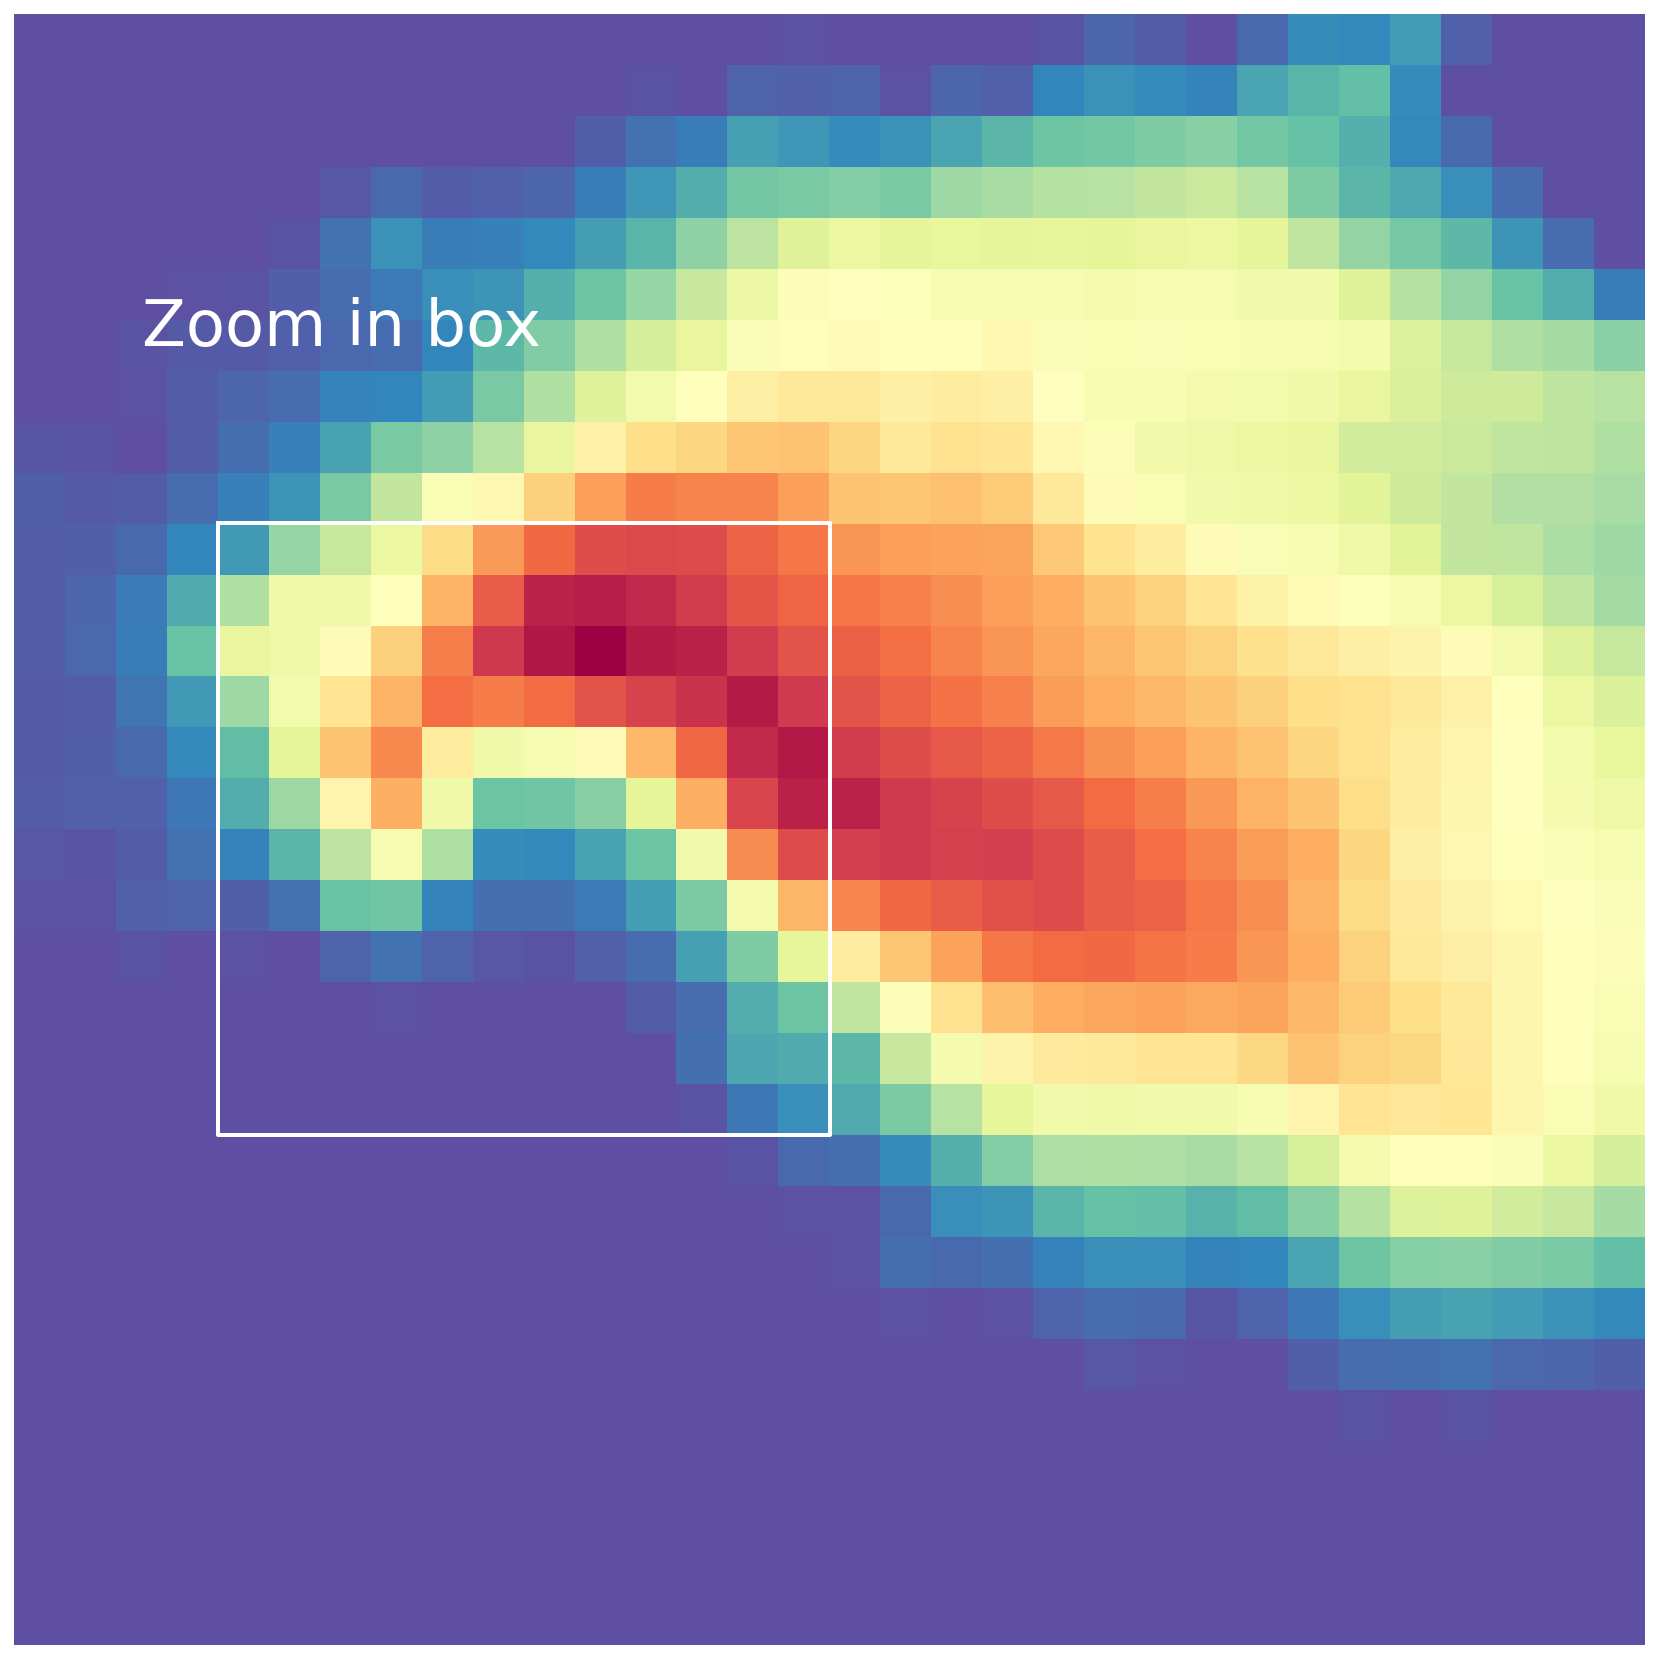

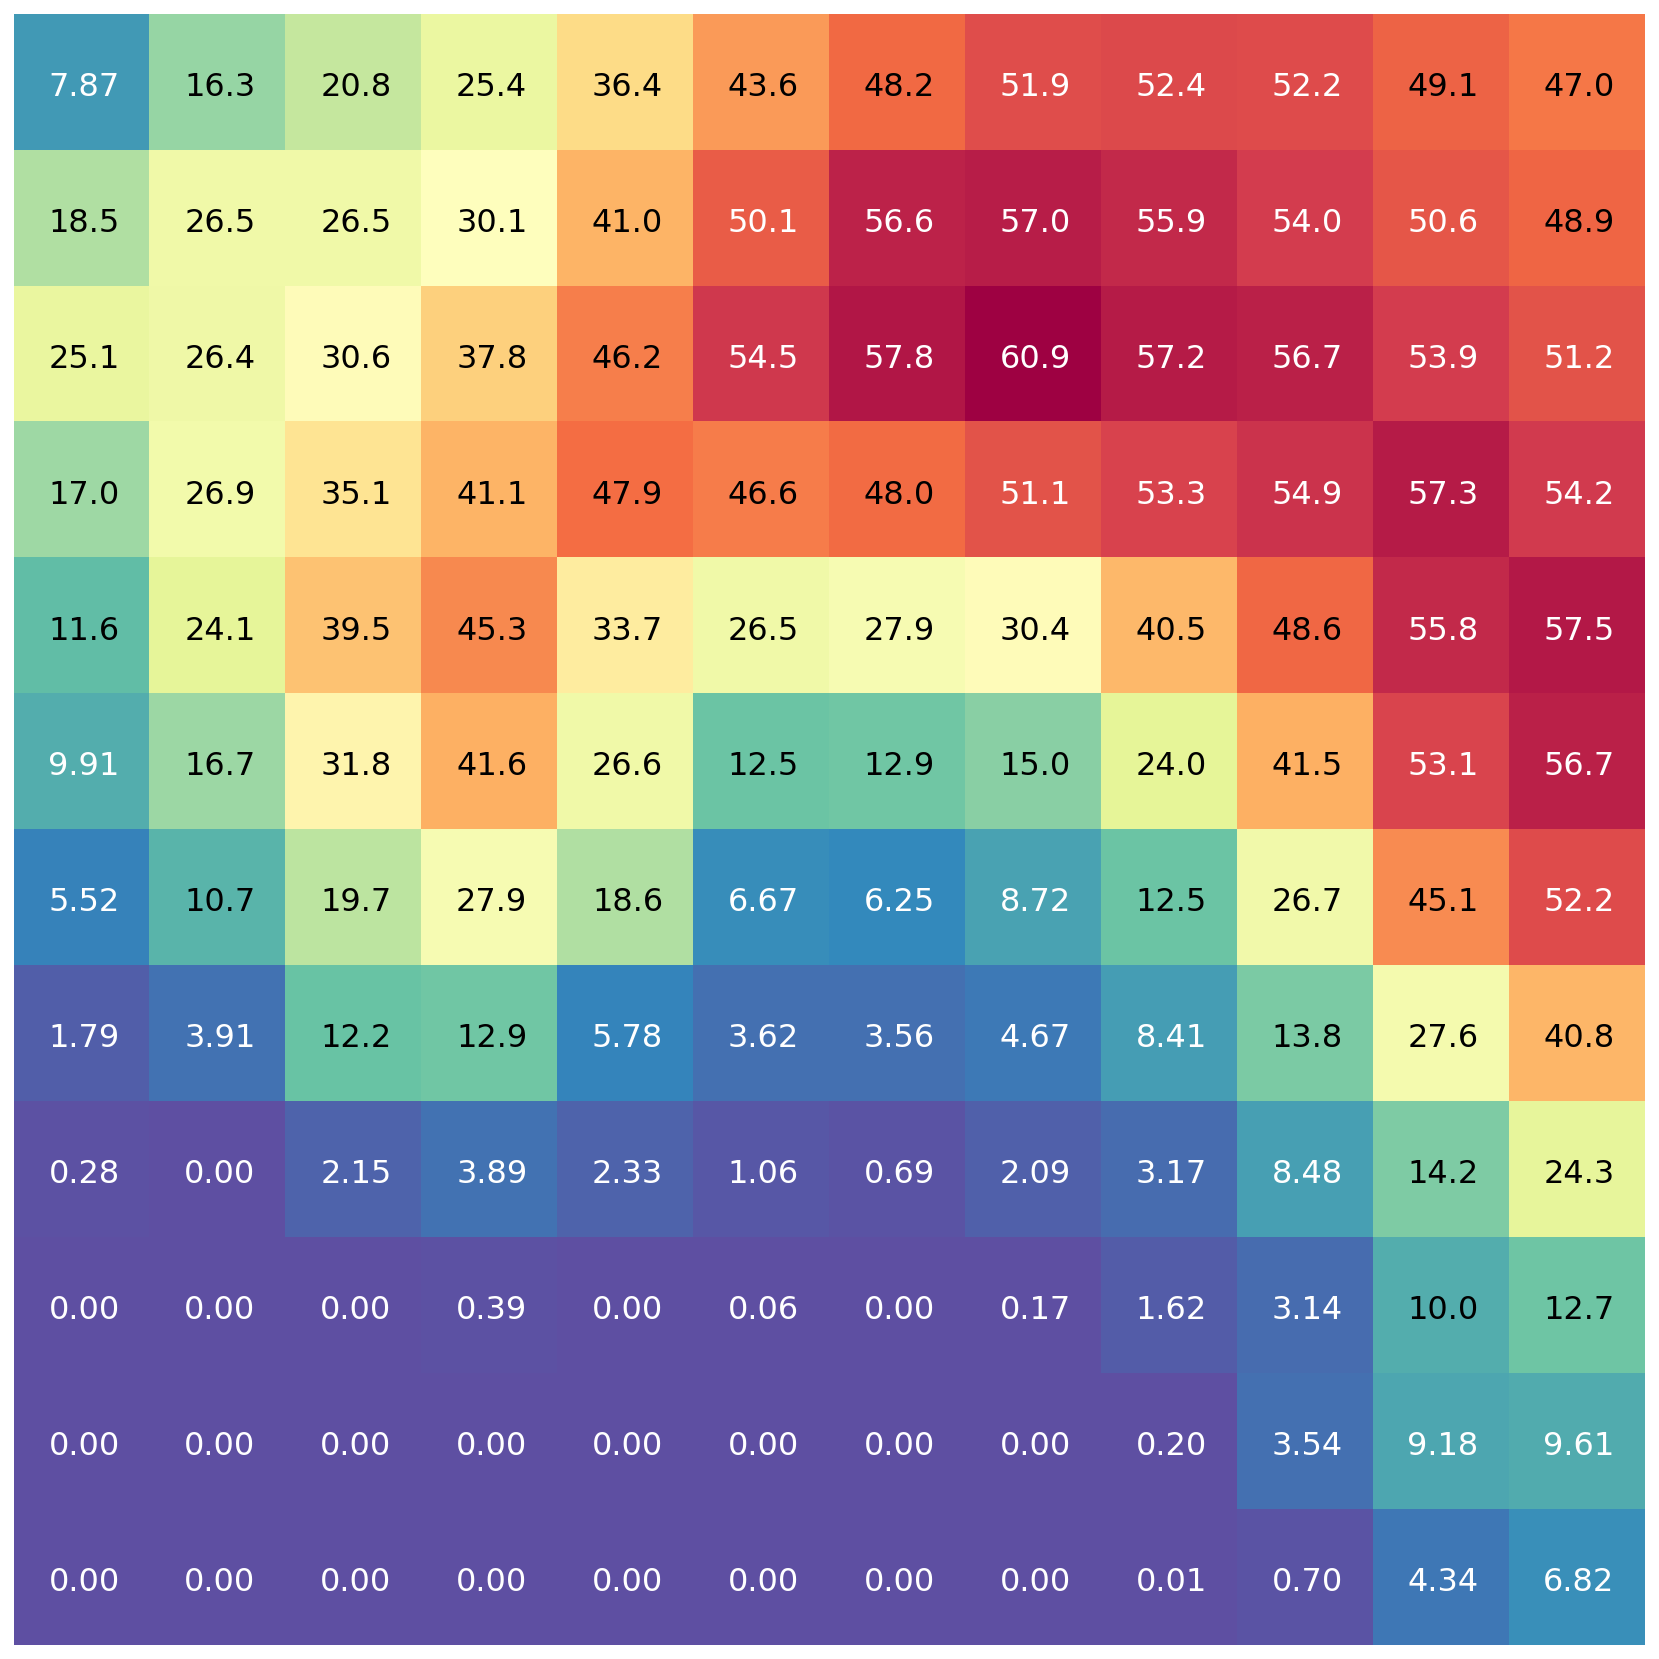

In [4]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/content/WAF_ML_Tutorial_Part2/scripts/')

#load contingency_table func
from aux_functions import show_vals


#make a big figure so we can see the pixels
plt.figure(figsize=(15,15))
plt.imshow(ds_sample.radar_image_matrix[:,:,0,0],vmin=0,vmax=60,cmap='Spectral_r')
plt.gca().axis('off')

#draw box to see where the next plot will zoom into
x_vertices = np.array([4.,16.,16.,4.,4.,])
y_vertices = np.array([10.,10.,22.,22.,10.])
plt.plot(x_vertices-0.5,y_vertices-0.5,'-w',lw=2)

# #add mannual annotation 
plt.text(2,6,'Zoom in box',color='w',fontsize=32)


#make a big figure so we can see the pixels
plt.figure(figsize=(15,15))
da = ds_sample.radar_image_matrix.isel(grid_row=slice(10,22),grid_column=slice(4,16),radar_height=0,radar_field=0)
plt.imshow(da,vmin=0,vmax=60,cmap='Spectral_r')
show_vals(da,plt.gca())
plt.gca().axis('off')


Hopefully this helps illustrate that images are just matrices of values.


Next, we will take a step-by-step look at the convolution process to demonstrate what a convolution does and how it is used in CNNs. 

#### Step 4: What are Convolutions?

I often find animations can be helpful for describing an idea. Below is an animated version of Figure 3 from the paper. Don't get bogged down in the math right now, just notice how the kernel (filter) is incrementally stepped through the image systematically. This example is the same 12x12 image (the zoom in) from above. 

<center><img src="../images/convolution_animation_01.gif" alt="drawing" width="600"/></center>

Hopefully it is more apperent now what a ```convolution``` is. At this point we have not shown any machine learning - this is simply an image processing technique (i.e., like a mathematical operator). For those more mathematically inclined, the convolution is: 

$$\begin{equation} p_{x,y}= \sum_{j=y-k}^{j=y+k}\sum_{i=x-k}^{i=x+k} w_{i,j} p_{i,j}, \label{e3} \end{equation}$$

where $p_{x,y}$ is the pixel value at position x,y in the image matrix and k is there kernel size. This equation is then iterated for all pixels in the image. 

Normally, the convolution kernel (the middle picture in the animation) has weights that are more sophisticated than what was shown. For example, you might have noticed the right image is the same as the left image, just with a white border around it. That is because the example uses the identity kernel to set the convolution weights. 

$$\begin{bmatrix} 0 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 0 \end{bmatrix}$$

Thus, the kernel is simply passing the middle pixel through with no change. Other common kernels in image processing are: 

##### **Sharpen:** 

$$\begin{bmatrix} 0 & -1 & 0 \\ -1 & 5 & -1 \\ 0 & -1 & 0 \end{bmatrix}$$

Here is this kernel being applied to our zoomed-in patch: 

<center><img src="../images/sharpen_image.png" alt="drawing" width="600"/></center>

and on the entire image:

<center><img src="../images/sharpen_image_full.png" alt="drawing" width="600"/></center>


##### **Blur** (i.e., mean)

$$ \frac{1}{9} \begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}$$

Likewise, here is the blur kernel applied to the zoomed-in patch 

<center><img src="../images/blur_image.png" alt="drawing" width="600"/></center>

and on the whole image:

<center><img src="../images/blur_image_full.png" alt="drawing" width="600"/></center>


I would reconmend checking out the webpage [here](https://en.wikipedia.org/wiki/Kernel_(image_processing)) for more examples. 


Again, we have not actually applied any machine learning so far. The discussion has soley been focused on the convolution operation.



#### Step 5: Implement a convolution with code

It is possible to manually code a convolution yourself, but for the sake of simpicty and speed, tensorflow has a convolutional layer that handles this for you:

```tf.keras.layers.Conv2D()```

We will need to configure the layer to use the desired set of weights, but this is relatively simple to do. 

2022-12-07 21:46:58.563763: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(-0.5, 33.5, 33.5, -0.5)

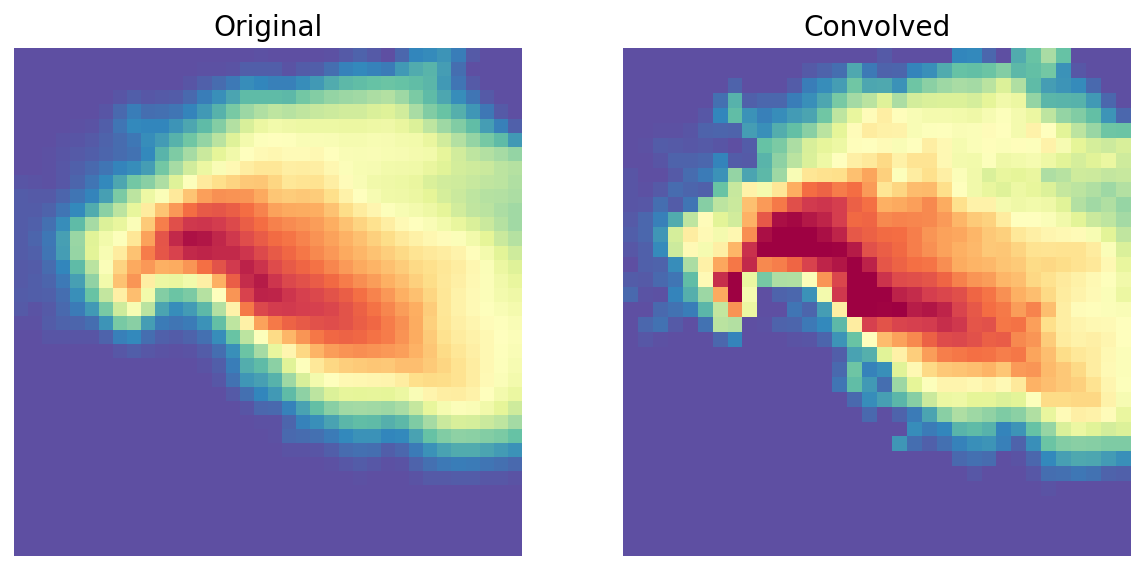

In [5]:
#get a high resoltion image to run through the conv. 
more_points = tf.image.resize(ds_sample.radar_image_matrix.isel(radar_height=slice(0,1),radar_field=0).values,[36,36])

#define the sharpen filter
kernel_weights = np.array([[ 0, -1, 0],[ -1,5,-1],[0,-1,0]])

#define conv with specific weights. otherwise they will be randomly initilaized. 
conv = tf.keras.layers.Conv2D(filters=1,kernel_size=3,input_shape=(36,36,1),weights=[kernel_weights[...,np.newaxis,np.newaxis]],use_bias=False)

#run the data through 
res = conv(more_points[np.newaxis,...])


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(more_points,vmin=0,vmax=60,cmap='Spectral_r')
ax1.set_title('Original')
ax1.axis('off')
#show result. 
ax2.imshow(res[0,:,:],vmin=0,vmax=60,cmap='Spectral_r')
ax2.set_title('Convolved')
ax2.axis('off')

As you hopefully can see, tensorflow's built-in convolution layer is a convenient and easy way to perform a convolution. 


#### Step 6: Try a new image 

Here is a fun exercise to help you become more familiar with convolutions. In the next code block, go find an image online, right click the image, copy the image address, and paste it in the ```url''' variable below. This code will perform a convolution on whatever image you choose.  For example, here we show a blur convolution for the AI2ES logo. Try changing the weights to see how they affect the convolution.

(-0.5, 257.5, 257.5, -0.5)

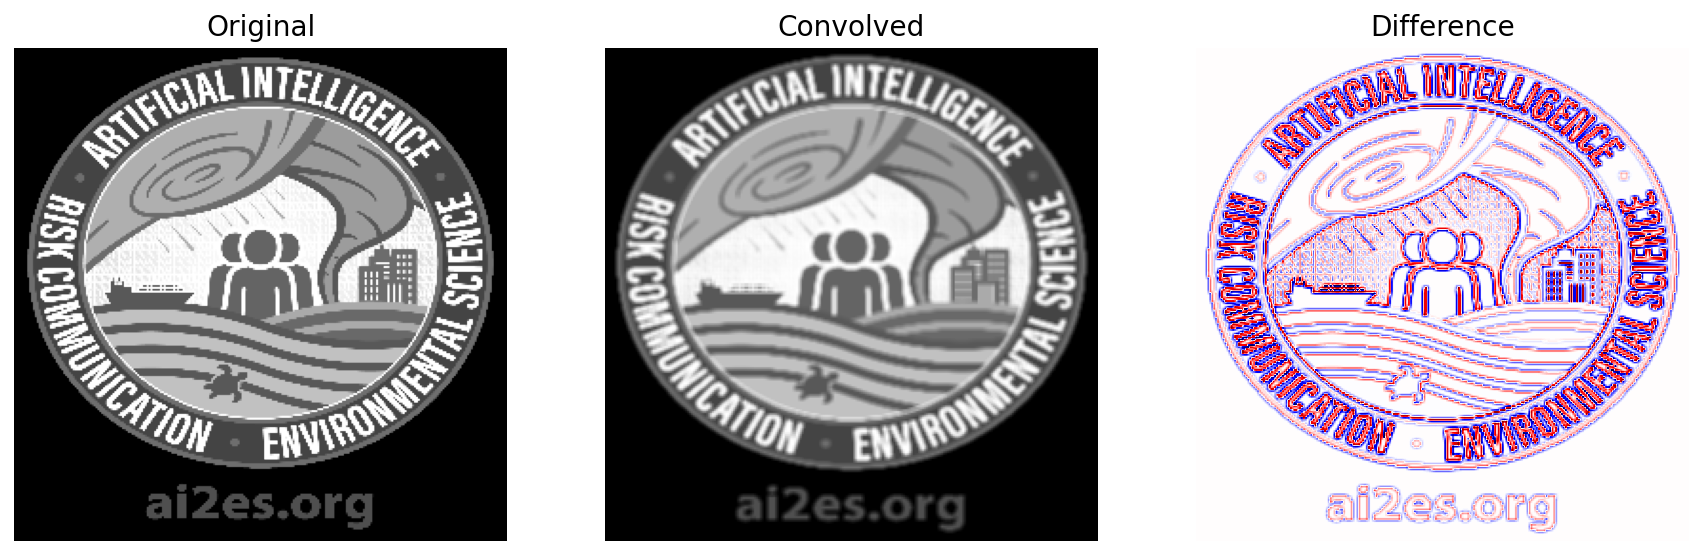

In [6]:
#define URL of image here. (right click an image online and get image address)
url = 'https://dopplerchase-ai2es-schooner-hpc.readthedocs.io/en/latest/_images/ai2es-logo-web-trans.png'

#load in some image packages, dont worry about these
from PIL import Image,ImageOps
import requests
from io import BytesIO

#this grabs the image and turns it into an array of data we can use
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = ImageOps.grayscale(img)
arr = np.array(img.convert('F'))
arr = arr[...,np.newaxis]


#reshape the image so this code works for any image given
arr = tf.image.resize(arr[np.newaxis,...],[260,260])


#define a filter!

#blur 
kernel_weights = np.array([[ 1, 1, 1],[ 1,1,1],[1,1,1]])*(1/9.)

#sharpen
# kernel_weights = np.array([[ 0, -1, 0],[ -1,5,-1],[0,-1,0]])

#define conv with specific weights
conv = tf.keras.layers.Conv2D(filters=1,kernel_size=3,input_shape=(260,260,1),weights=[kernel_weights[...,np.newaxis,np.newaxis]],use_bias=False)

#run the conv
res = conv(arr)


#plot it up. a figure with 3 subplots in the column direction 
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5),facecolor='w')

ax1.imshow(arr[0],vmin=0,vmax=255,cmap='Greys_r')
ax1.set_title('Original')
ax1.axis('off')
#show result. 
ax2.imshow(res[0,:,:],vmin=0,vmax=255,cmap='Greys_r')
ax2.set_title('Convolved')
ax2.axis('off')

ax3.imshow(arr[0,1:-1,1:-1]-res[0,:,:],vmin=-100,vmax=100,cmap='seismic')
ax3.set_title('Difference')
ax3.axis('off')


How about a space cowboy?

(-0.5, 257.5, 257.5, -0.5)

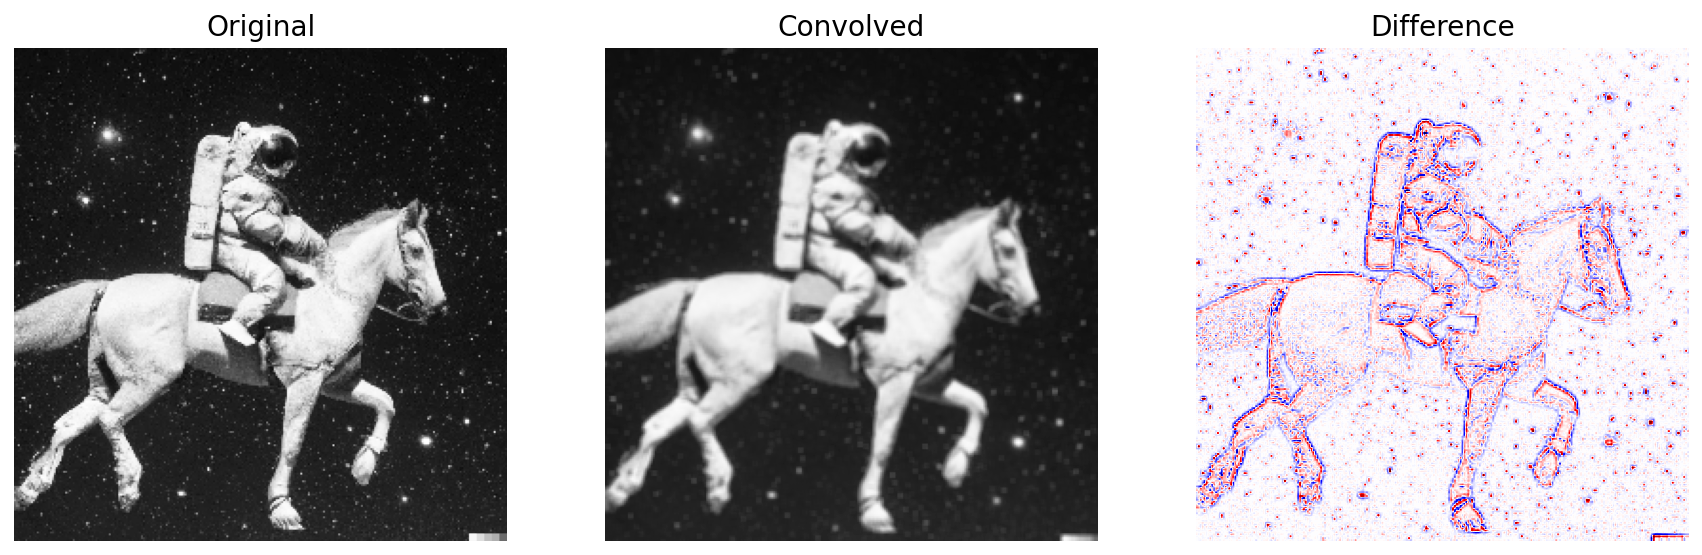

In [7]:
url = 'https://cdn.openai.com/dall-e-2/demos/text2im/astronaut/horse/photo/0.jpg'

#load in some image packages, dont worry about these
from PIL import Image,ImageOps
import requests
from io import BytesIO

#this grabs the image and turns it into an array of data we can use
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = ImageOps.grayscale(img)
arr = np.array(img.convert('F'))
arr = arr[...,np.newaxis]


#reshape the image so this code works for any image given
arr = tf.image.resize(arr[np.newaxis,...],[260,260])


#define a filter!

#blur 
kernel_weights = np.array([[ 1, 1, 1],[ 1,1,1],[1,1,1]])*(1/9.)

#sharpen
# kernel_weights = np.array([[ 0, -1, 0],[ -1,5,-1],[0,-1,0]])

#define conv with specific weights
conv = tf.keras.layers.Conv2D(filters=1,kernel_size=3,input_shape=(260,260,1),weights=[kernel_weights[...,np.newaxis,np.newaxis]],use_bias=False)

#run the conv
res = conv(arr)


#plot it up. a figure with 3 subplots in the column direction 
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

ax1.imshow(arr[0],vmin=0,vmax=255,cmap='Greys_r')
ax1.set_title('Original')
ax1.axis('off')
#show result. 
ax2.imshow(res[0,:,:],vmin=0,vmax=255,cmap='Greys_r')
ax2.set_title('Convolved')
ax2.axis('off')

ax3.imshow(arr[0,1:-1,1:-1]-res[0,:,:],vmin=-100,vmax=100,cmap='seismic')
ax3.set_title('Difference')
ax3.axis('off')

#### Step 7: Padding...

If you consider this gif again, look closely at the edge of the right image: 

<center><img src="../images/convolution_animation_01.gif" alt="drawing" width="600"/></center>

See how there is a border of no data showing up around the image? This is not a bug. The convolution kernel shown here processes data from the left, right, top, and bottom of the center pixel.  But that means the kernel cannot process pixels around the edge of the image, as there is no data available on at least one side of the pixel.  As a result, the kernel will skip those pixels and the output will be smaller than the input.  In other words, convolutions will actually reduce the resolution of the image. 

A way to prevent the loss of pixels is a process known as **Padding**. This is where the *input* image is padded with 0s, such that the output of the convolution now keeps the same shape as the original image. This next code block adds in a zero padding around the image. 

(-0.5, 13.5, 13.5, -0.5)

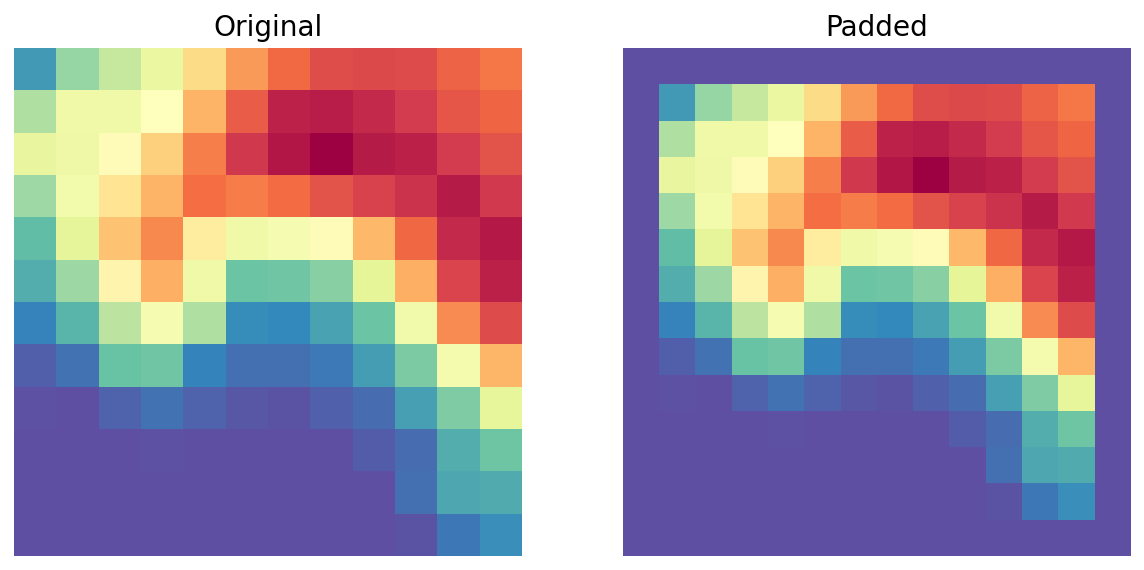

In [7]:
import copy 

#define image on the left
Z_old = copy.deepcopy(da.values)

paddings = tf.constant([[1, 1], [1, 1]])
Z = tf.pad(Z_old, paddings, mode='CONSTANT', constant_values=0, name=None)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(Z_old,vmin=0,vmax=60,cmap='Spectral_r')
ax1.set_title('Original')
ax1.axis('off')
#show result. 
ax2.imshow(Z,vmin=0,vmax=60,cmap='Spectral_r')
ax2.set_title('Padded')
ax2.axis('off')

Here is the same gif as before, but now with the padded image to show you that the original image size is now preserved. 

<center><img src="../images/convolution_animation_01_padded.gif" alt="drawing" width="600"/></center>

Tensorflow has implemented this in the code for us. All we need to do is make sure the ```padding="same"``` is set in the convolution function:

(-0.5, 35.5, 35.5, -0.5)

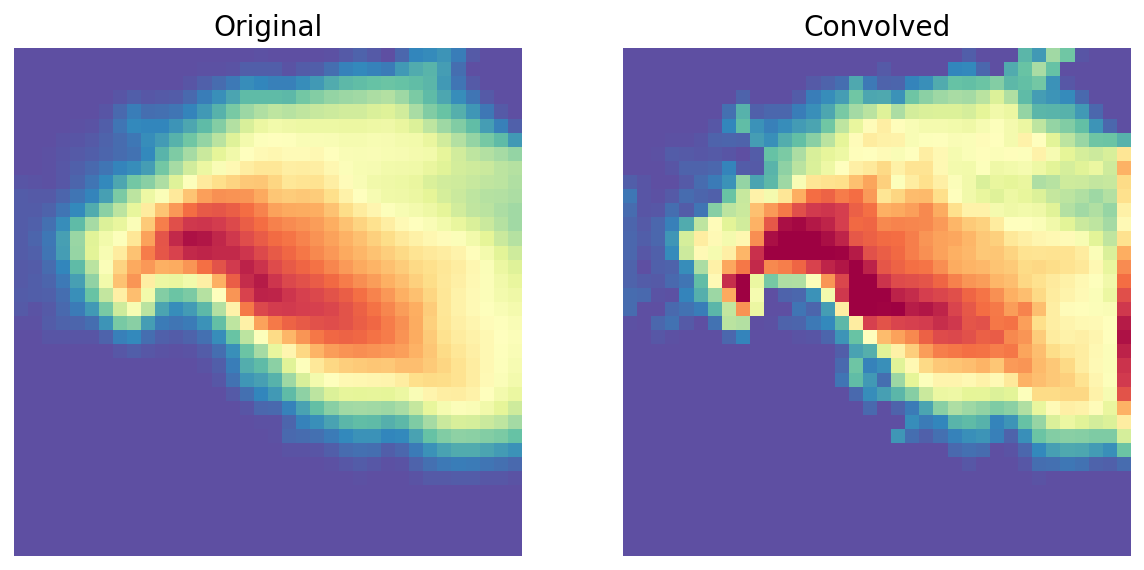

In [12]:
#get a high resoltion image to run through the conv. 
more_points = tf.image.resize(ds_sample.radar_image_matrix.isel(radar_height=slice(0,1),radar_field=0).values,[36,36])

#define the sharpen filter
kernel_weights = np.array([[ 0, -1, 0],[ -1,5,-1],[0,-1,0]])
# kernel_weights = np.array([[ 1, 1, 1],[ 1,1,1],[1,1,1]])*(1/9.)

#define conv with specific weights. otherwise they will be randomly initilaized. 
conv = tf.keras.layers.Conv2D(filters=1,kernel_size=3,input_shape=(36,36,1),weights=[kernel_weights[...,np.newaxis,np.newaxis]],use_bias=False,padding='same') #<--- this is the change here

#run the data through 
res = conv(more_points[np.newaxis,...])


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(more_points,vmin=0,vmax=60,cmap='Spectral_r')
ax1.set_title('Original')
ax1.axis('off')
#show result. 
ax2.imshow(res[0,:,:],vmin=0,vmax=60,cmap='Spectral_r')
ax2.set_title('Convolved')
ax2.axis('off')

Notice the line of higher (red) values on the far-right side of the right image. This is a result of the padding. The sharpen filter in particular tends to exhibit some potentially undesireable behavior when the kernel is half-full of 0s.

While it looks weird here, remember we still haven't done any machine learning yet. So maybe for our example here, the sharpen filter isn't the best choice for tornado classification. 

In the next notebook, we will apply what we've learned here by training a CNN to detect lightning in an image using the ```sub-sevir``` dataset.
